# HR Analytics Employee Retention

* **Author:** Alvaro Villamizar
* **Source:** https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction/data 

Employee retention is defined as the organization's ability to prevent employee turnover, or the loss of organizational talent over a period of time, either voluntary or involuntary.  According to the Society for Human Resource Management (SHRM), the cost to replace just one employee can be three to four times the position's salary. In the US, the overall cost of employee turnover in 2020, was 630 billion dollars. Keeping turnover rates low helps you avoid these expenses and frees up money budget to invest in people's development, benefits, and more.

## Table of contents <a id='table_contents'></a>
#### [1. Basic Data Preprocessing](#preprocessing)
&nbsp; [**1.1** Initial EDA and Data Cleaning](#initial_analysis) \
&nbsp; [**1.2** Handling Duplicate Data](#duplicates)

#### [2. Data Exploratory Analysis](#eda)
&nbsp; [**2.1** Pearson Correlation Matrix](#correlation) \
&nbsp; [**2.2** Handling Outliers](#outliers)

#### [3. Survival Analysis](#survival)
&nbsp; [**3.1** Employee Survival per variable](#survivalvariable) \
&nbsp; &nbsp; &nbsp; &nbsp;   [**3.1.1** Salary](#salary) \
&nbsp; &nbsp; &nbsp; &nbsp;   [**3.1.2**. Department](#department) \
&nbsp; &nbsp; &nbsp; &nbsp;   [**3.1.3**. Promotion](#promotion) \
&nbsp; &nbsp; &nbsp; &nbsp;   [**3.1.4**. Monthly Hours](#monthly) \
&nbsp; &nbsp; &nbsp; &nbsp;   [**3.1.5**. Last Evaluation](#evaluation) \
&nbsp; &nbsp; &nbsp; &nbsp;   [**3.1.6**. Satisfaction](#satisfaction) \
&nbsp; &nbsp; &nbsp; &nbsp;   [**3.1.7**. Work Accidents](#accidents) \
&nbsp; &nbsp; &nbsp; &nbsp;   [**3.1.8**. Number of Projects](#projects) \
&nbsp; [**3.2** Cox Proportional Hazard model](#coxproportional)

#### [4. Machine Learning Implementation](#mlimplementation)
&nbsp; [**4.1** Model Comparisons](#models) \
&nbsp; &nbsp; &nbsp; &nbsp;    [**4.1.1** Tuned Decision Tree](#decision) \
&nbsp; &nbsp; &nbsp; &nbsp;    [**4.1.1** Random Forest Classificator](#forest) \
&nbsp; &nbsp; &nbsp; &nbsp;    [**4.1.1** XGBoost](#xgboost) \
&nbsp; [**4.2** Final Model](#finalmodel)


### Importing Libraries

In [127]:
# OPERATIONAL IMPORTS                
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from scipy.stats import pearsonr

# MODELLING IMPORTS                  
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# VISUALIZATION IMPORTS              
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from sklearn.tree import plot_tree

In [128]:
import os
os.chdir('C:\\Users\\claud\\PythonScripts')

## Basic Data Preprocessing <a id='preprocessing'></a>
In this section, the purpose is to make a preliminar look at our data, check for missing or incorrect values

### Loading Data and Initial Analysis <a id='initial_analysis'></a>

In [129]:
# Read the data set
df0 = pd.read_csv('Google DAC/Datasets/HR_comma_sep.csv')
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [130]:
df0 = df0.rename(columns = {'Work_accident': 'work_accident', 'Department': 'department', 
                            'average_montly_hours': 'average_monthly_hours', 'time_spend_company': 'tenure'})

### Dataset description

This dataset contains 15000 entries and 10 columns. Each row describes unique employee conditions in the company. The meaning of each column is describe as follows:

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

As mentioned in the table above, Left is an event which indicates whether an employee left or not. And, time_spend_company measures how long an employee stayed in the company. Both of these variables can be used to employ a survival analysis to find relationships to explain why those employees decided to leave.

In [131]:
print('\033[1m' +'Unique Values in the categorical variables:' + '\033[0m \n')

print('\033[1m' + 'Salary Categories:' + '\033[0m', df0.salary.unique(), '\n')

print('\033[1m' +'Department Categories:' + '\033[0m', df0.department.unique())

Unique Values in the categorical variables: 

Salary Categories: ['low' 'medium' 'high'] 

Department Categories: ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


In [132]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


There are no negative values, or obvious outliers within the data.

### Check for Duplicates <a id='duplicates'></a>

In [133]:
print('The dataset has:', df0.duplicated().sum(), 'duplicates')

df0[df0.duplicated()].head(n=7)

The dataset has: 3008 duplicates


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
1516,0.40,0.50,2,127,3,0,1,0,IT,low
1616,0.37,0.46,2,156,3,0,1,0,sales,low


In [134]:
# Because of the presence of 3008 duplicate entries, we are going to remove them from the final dataset.
df0= df0[~df0.duplicated()]
df_copy = df0
df0.shape 

(11991, 10)

## Exploratory Data Analysis <a id='eda'></a>

### Target Variable: Left

The aim of this project is to predict whether an employee is going to left the company and which aspects make the employee to do so. 

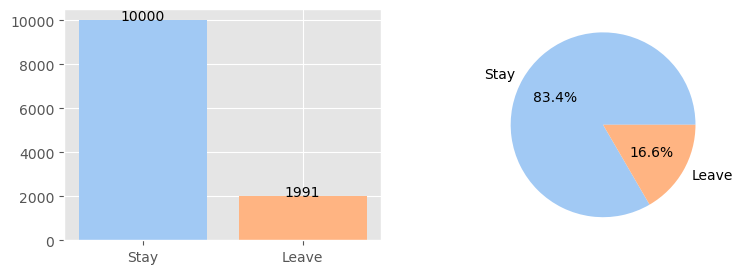

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))

data = [df0['left'].value_counts()[0], df0['left'].value_counts()[1]]
labels = ['Stay', 'Leave']
colors = sns.color_palette('pastel')[0:5]

#Create a bar chart
axs[0].bar(labels, data, color=colors)
for i, v in enumerate(data):
    axs[0].text(i, v, str(v), color='black', ha='center')
plt.grid()
    
#create pie chart
axs[1].pie(data , labels = labels, colors = colors, autopct='%.1f%%')

plt.show()

In [135]:
ordinal_encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])
df0['salary_encoded'] = ordinal_encoder.fit_transform(df0[['salary']]).astype(int)
df0 = df0.drop(columns=['salary'])

These graphs show that 'left' variable is unbalance, since for each employee who left, there are 5 employee who stayed.

## Correlation Matrix <a id='correlation'></a>

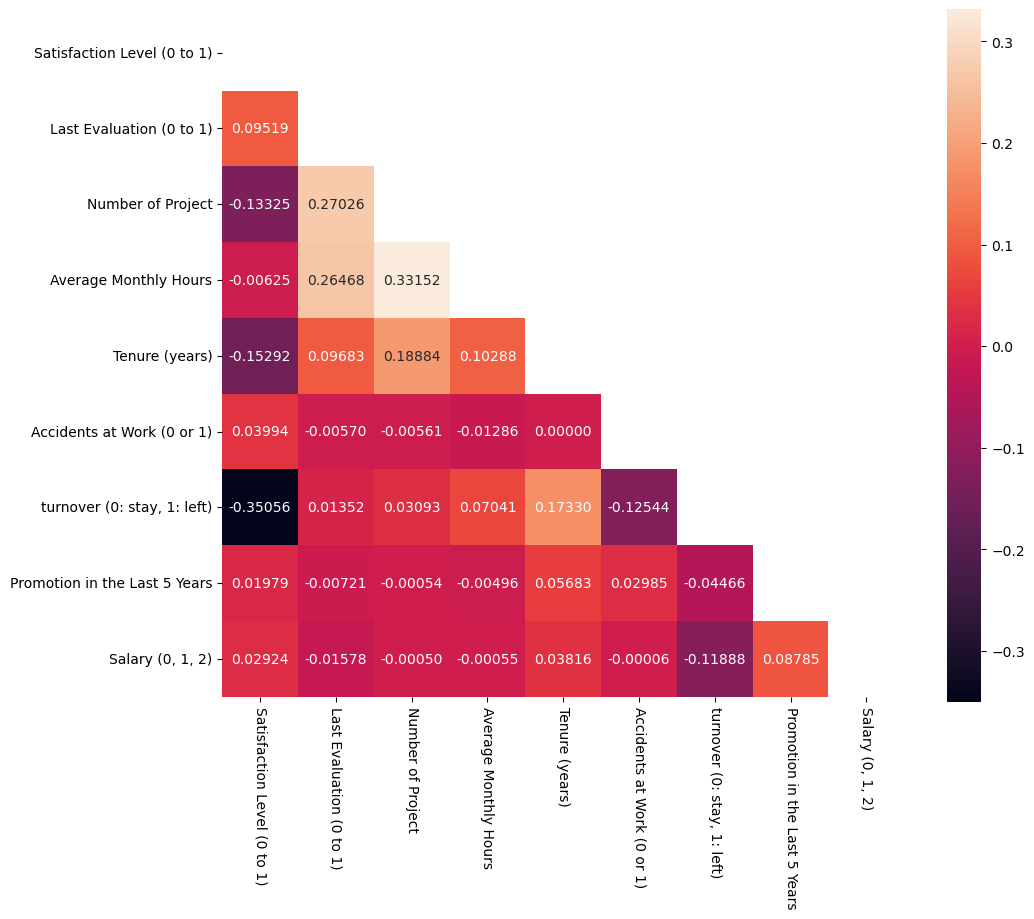

In [18]:
# Pearson Correlation
plt.figure(figsize=(11,9))

corr = df0[['satisfaction_level',
                   'last_evaluation',
                   'number_project',
                   'average_monthly_hours',
                   'tenure',
                   'work_accident',
                   'left',
                   'promotion_last_5years',
                   'salary_encoded']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
corr_matrix = corr.mask(mask)

ax = sns.heatmap(corr_matrix, annot=True, annot_kws={'size': 10}, fmt='.5f', square = True)

labels = ['Satisfaction Level (0 to 1)',
                   'Last Evaluation (0 to 1)',
                   'Number of Project',
                   'Average Monthly Hours',
                   'Tenure (years)',
                   'Accidents at Work (0 or 1)',
                   'turnover (0: stay, 1: left)',
                   'Promotion in the Last 5 Years',
                   'Salary (0, 1, 2)']
ax.set_xticklabels(labels, rotation = 270, ha= 'center', fontsize=10)
ax.set_yticklabels(labels, rotation = 0, ha= 'right', fontsize=10)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)

In [136]:
department = df0.department
replacement = dict(
    [  
        ['sales', 0],
        ['accounting', 1],
        ['hr', 2],
        ['technical', 3],
        ['support', 4],
        ['management', 5],
        ['IT', 6],
        ['product_mng', 7],
        ['marketing', 8],
        ['RandD', 9]
    ])
df0['department'] = department.replace(replacement)

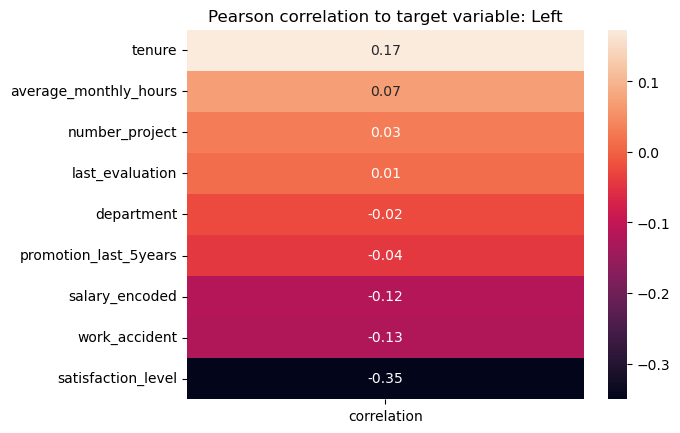

In [21]:
corr = df0.drop('left', axis=1).corrwith(df0['left']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f')
plt.title('Pearson correlation to target variable: Left')
plt.show()

## Handling Outliers <a id='outliers'></a>

In [128]:
print(df0.columns)
columns = ['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident',
       'promotion_last_5years', 'salary_encoded']

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary_encoded'],
      dtype='object')


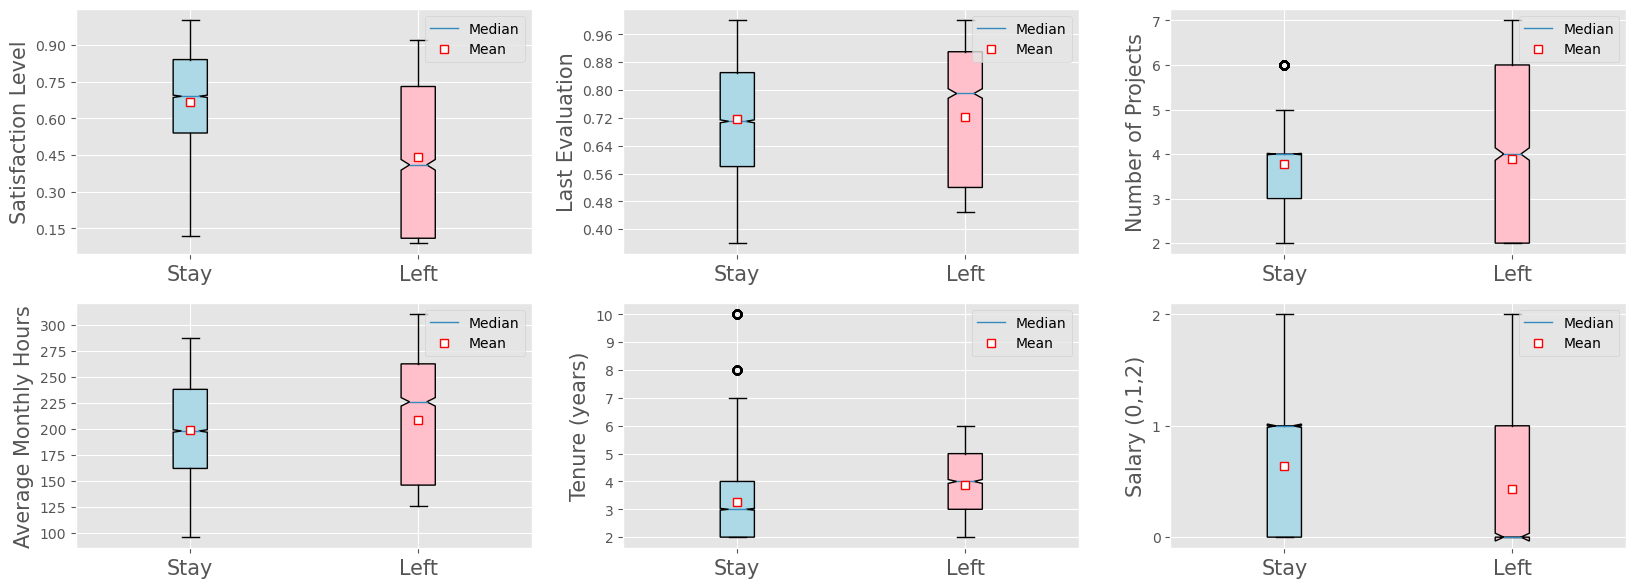

In [132]:
columns = ['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'salary_encoded']
y_labels = ['Satisfaction Level', 'Last Evaluation', 'Number of Projects', 
            'Average Monthly Hours', 'Tenure (years)', 'Salary (0,1,2)']

fig, ax = plt.subplots(2,3, figsize=(20,7))

for idx, feature in enumerate(columns):
    list0 = df0[df0['left'] == 0][feature].tolist()
    list1 = df0[df0['left'] == 1][feature].tolist()
    column = [list0, list1]
    
    row_idx = idx // 3
    col_idx = idx % 3
    
    box = ax[row_idx, col_idx].boxplot(column, notch = True, patch_artist = True, showmeans = True,
                                      meanprops = {'marker': 's', 'markerfacecolor': 'white', 'markeredgecolor': 'red'})
    
    ax[row_idx, col_idx].yaxis.set_major_locator(MaxNLocator(integer = True))
    ax[row_idx, col_idx].set_xticklabels(['Stay', 'Left'], size = 15)
    ax[row_idx, col_idx].set_ylabel(y_labels[idx], size = 15)
    
    colors = ['lightblue', 'pink']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        
    ax[row_idx, col_idx].legend([box['medians'][0], box['means'][0]], ['Median', 'Mean'], loc = 'upper right')
    
plt.show()

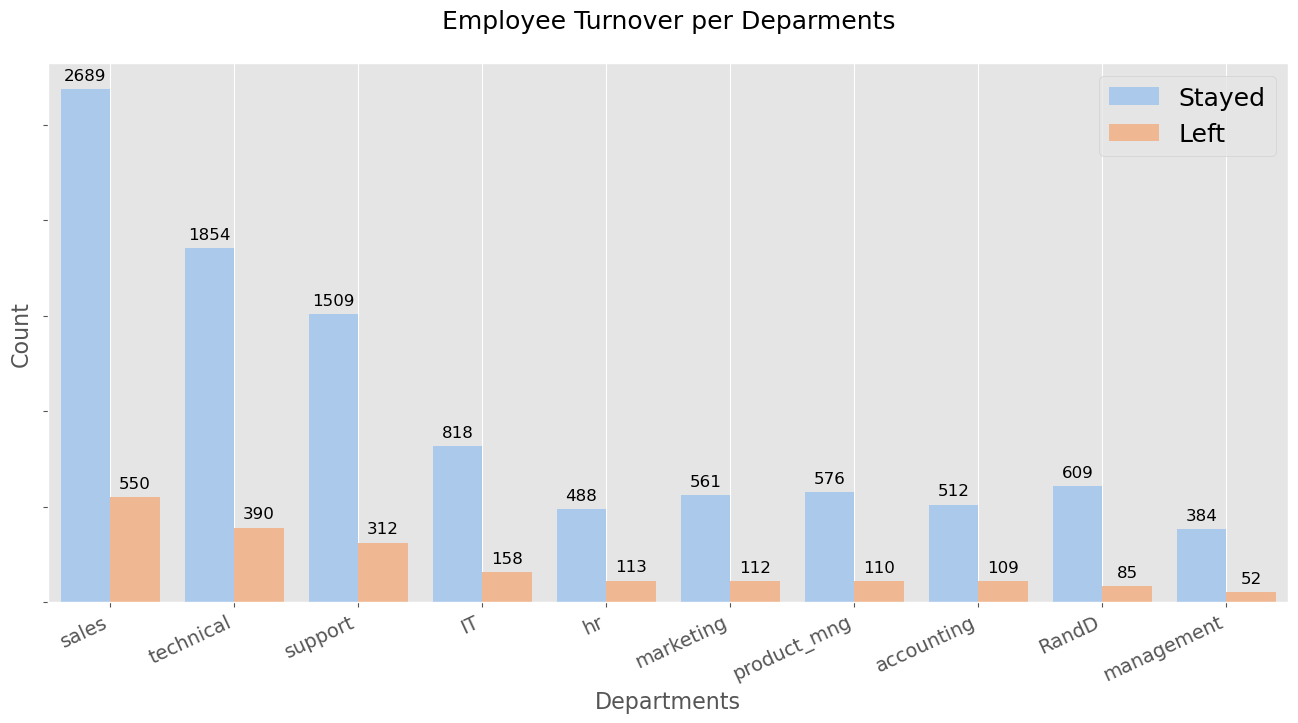

In [268]:
reverse_replacement = {v: k for k, v in replacement.items()}
left_replacement = {0: 'Stayed', 1: 'Left'}

# Create a temporary DataFrame for the plot

plt.figure(figsize=(16,7))
plt.title('Employee Turnover per Deparments', size=18, y=1.05)
order_by_left = df0.groupby('department')['left'].sum().sort_values(ascending=False).index
ax = sns.countplot(x='department', hue='left', data=df0, palette='pastel', order=order_by_left)
ax.set_xticklabels([reverse_replacement[int(label.get_text())] for label in ax.get_xticklabels()])
plt.legend(labels=['Stayed', 'Left'], loc='upper right', prop={'size' : 18})

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right', size=14)
ax.set_yticklabels([])
ax.set_xlabel('Departments', size=16)
ax.set_ylabel('Count', size=16)
plt.grid()
plt.show()

# Survival Analysis <a id='survival'></a>

In [137]:
eventvar = df0['left']
timevar = df0['tenure']
plt.style.use('ggplot')

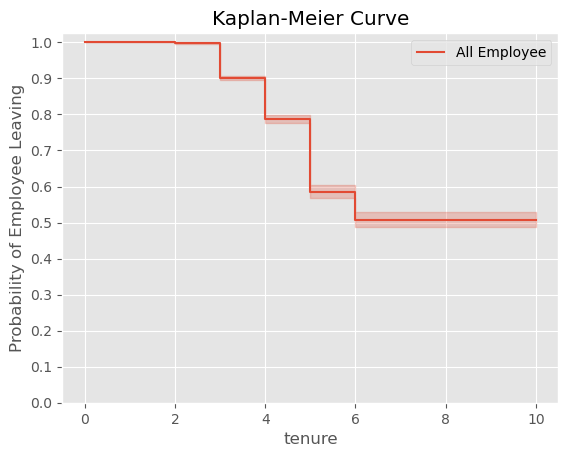

In [138]:
kmf = KaplanMeierFitter()
kmf.fit(timevar, event_observed = eventvar, label= 'All Employee')
kmf.plot()
plt.xlabel(timevar.name)
plt.ylabel('Probability of Employee Leaving')
plt.title('Kaplan-Meier Curve')
plt.yticks(np.linspace(0,1,11))
plt.show()

In this graph, we can observed that the company conserved 50% of his employees after 10 years, and the other half quit between 3 and 6 years of work. In each year, there is a 10% change of loss, but in the 5th year there was a loss of 20%.

## Salary <a id='salary'></a>

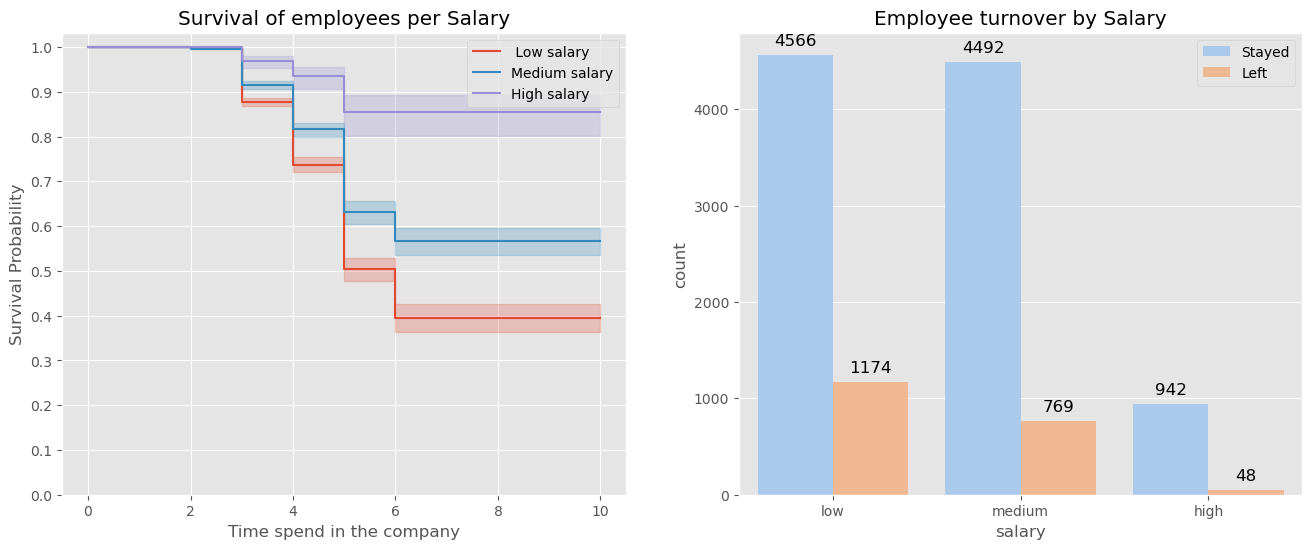

<Figure size 640x480 with 0 Axes>

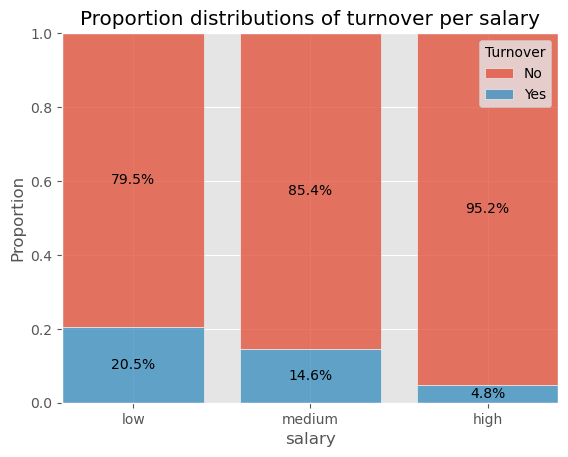

<Figure size 640x480 with 0 Axes>

In [139]:
low_salary = (df0['salary_encoded'] == 0)
medium_salary = (df0['salary_encoded'] == 1)
high_salary = (df0['salary_encoded'] == 2)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

kmf.fit(timevar[low_salary],event_observed = eventvar[low_salary],label = " Low salary")
plot1 = kmf.plot(ax = axs[0])

kmf.fit(timevar[medium_salary],event_observed = eventvar[medium_salary],label = "Medium salary")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[high_salary],event_observed = eventvar[high_salary],label = "High salary")
plot3 = kmf.plot(ax = plot2)

axs[0].set_title('Survival of employees per Salary')
axs[0].set_xlabel('Time spend in the company')
axs[0].set_ylabel('Survival Probability')
axs[0].set_yticks(np.linspace(0,1,11))

axs[1] = sns.countplot(x='salary',hue='left', data=df_copy, palette='pastel')
for p in axs[1].patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
axs[1].legend(labels=['Stayed', 'Left'], loc='upper right', prop={'size' : 10})
axs[1].set_title('Employee turnover by Salary')
plt.show()

# Stacked Bar Chart

fig, ax = plt.subplots()
f = sns.histplot(
    data=df_copy, ax = ax,
    x="salary", hue="left",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8)
legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.legend(handles, ['No', 'Yes'], title='Turnover')

plt.title('Proportion distributions of turnover per salary')

for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
plt.show()

## Departments <a id='department'></a>

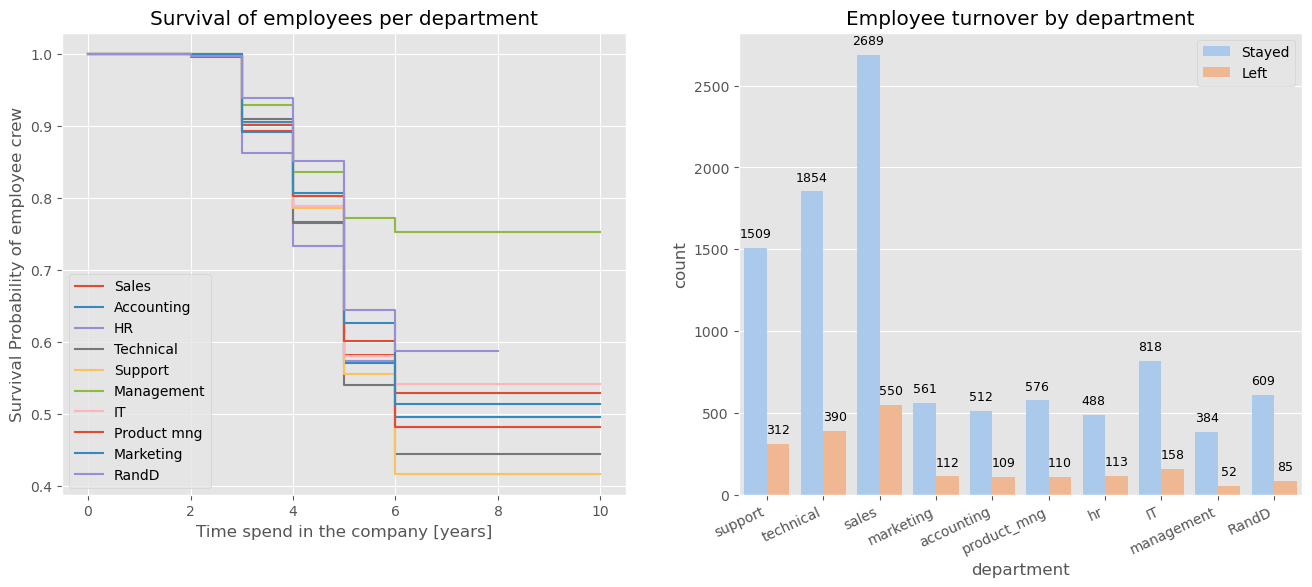

C:\Users\claud\AppData\Local\Temp\ipykernel_11764\154003085.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right')


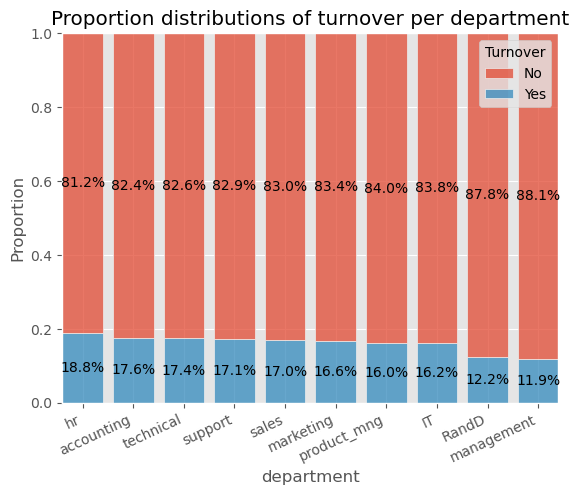

In [60]:
sales = (df0['department'] == 0)
accounting = (df0['department'] ==  1)
hr = (df0['department'] ==  2)
technical = (df0['department'] ==  3)
support = (df0['department'] ==  4)
management = (df0['department'] ==  5)
IT =  (df0['department'] ==  6)
product_mng = (df0['department'] ==  7)
marketing = (df0['department'] ==  8)
RandD = (df0['department'] ==  9)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

kmf.fit(timevar[sales],event_observed = eventvar[sales],label = "Sales")
plot1 = kmf.plot(ax = axs[0], ci_show=False)

kmf.fit(timevar[accounting],event_observed = eventvar[accounting],label = "Accounting")
plot2 = kmf.plot(ax = plot1, ci_show=False)

kmf.fit(timevar[hr],event_observed = eventvar[hr],label = "HR")
plot3 = kmf.plot(ax = plot2, ci_show=False)

kmf.fit(timevar[technical],event_observed = eventvar[technical],label = "Technical")
plot4 = kmf.plot(ax = plot3, ci_show=False)

kmf.fit(timevar[support],event_observed = eventvar[support],label = "Support")
plot5 = kmf.plot(ax = plot4, ci_show=False)

kmf.fit(timevar[management],event_observed = eventvar[management],label = "Management")
plot6 = kmf.plot(ax = plot5, ci_show=False)

kmf.fit(timevar[IT],event_observed = eventvar[IT],label = "IT")
plot7 = kmf.plot(ax = plot6, ci_show=False)

kmf.fit(timevar[product_mng],event_observed = eventvar[product_mng],label = "Product mng")
plot8 = kmf.plot(ax = plot7, ci_show=False)

kmf.fit(timevar[marketing],event_observed = eventvar[marketing],label = "Marketing")
plot9 = kmf.plot(ax = plot8, ci_show=False)

kmf.fit(timevar[RandD],event_observed = eventvar[RandD],label = "RandD")
plot10 = kmf.plot(ax = plot9, ci_show=False)

axs[0].set_title('Survival of employees per department')
axs[0].set_xlabel('Time spend in the company [years]')
axs[0].set_ylabel('Survival Probability of employee crew')

order = ['support', 'technical', 'sales', 'marketing', 'accounting', 'product_mng', 'hr', 'IT', 'management', 'RandD']
axs[1] = sns.countplot(x='department',hue='left', data=df_copy, palette='pastel', order = order)
for p in axs[1].patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 10),
                    textcoords='offset points')
axs[1].legend(labels=['Stayed', 'Left'], loc='upper right', prop={'size' : 10})
axs[1].set_title('Employee turnover by department')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=25, horizontalalignment='right')
plt.show()

# Stacked Bar Chart
df_copy['department'] = pd.Categorical(df_copy['department'], ['hr', 'accounting', 'technical', 
            'support', 'sales', 'marketing', 'product_mng', 'IT', 'RandD', 'management'])

fig, ax = plt.subplots()
f = sns.histplot(
    data=df_copy, ax = ax,
    x="department", hue="left",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8)
legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.legend(handles, ['No', 'Yes'], title='Turnover')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
plt.title('Proportion distributions of turnover per department')

for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
    
plt.show()


This graph shows the relationship between every employee per deparment and their time spend in the company. We can notice that the Management Department has the highest employee retentions of all departments, loosing 20% within 6 years of work, and the departments with the lowest employee retentions are: Support, Technical, and both Product Management and HR.

- The Support department loose 60% of the work crew within 6 years of work.
- The Technical department loose 55% of the work crew within 6 years of work.
- The Product Management and Human Resource deparment loose 50% of the work crew within 6 years of work.

## Promotion in 5 years <a id='promotion'></a>

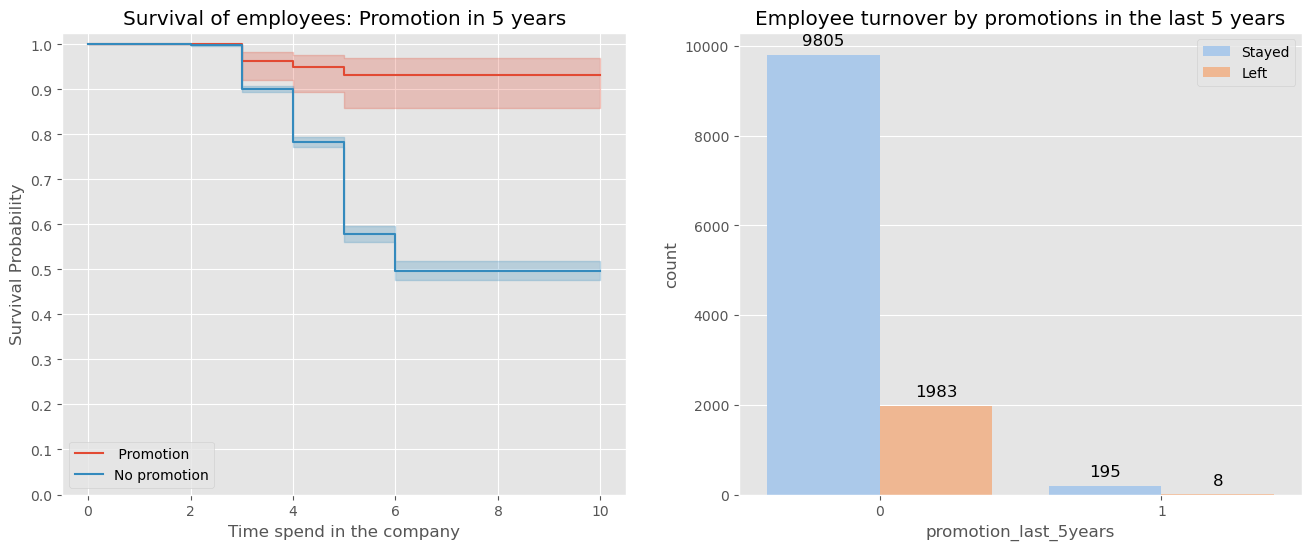

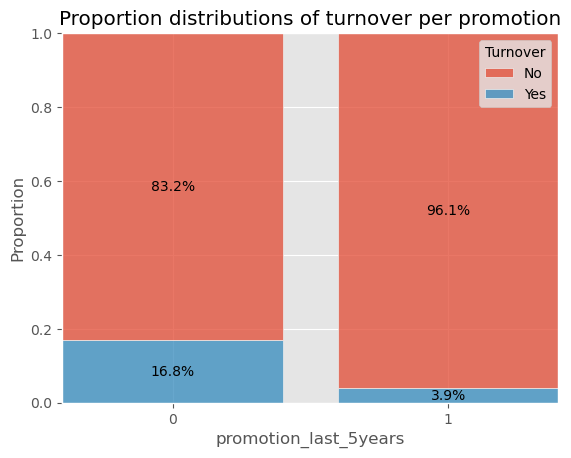

In [61]:
no_prom = (df0['promotion_last_5years'] == 1)
prom = (df0['promotion_last_5years'] == 0)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

kmf.fit(timevar[no_prom],event_observed = eventvar[no_prom],label = " Promotion")
plot1 = kmf.plot(ax = axs[0])

kmf.fit(timevar[prom],event_observed = eventvar[prom],label = "No promotion")
plot2 = kmf.plot(ax = plot1)

axs[0].set_title('Survival of employees: Promotion in 5 years')
axs[0].set_xlabel('Time spend in the company')
axs[0].set_ylabel('Survival Probability')
axs[0].set_yticks(np.linspace(0,1,11))

axs[1] = sns.countplot(x='promotion_last_5years',hue='left', data=df_copy, palette='pastel')
for p in axs[1].patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
axs[1].legend(labels=['Stayed', 'Left'], loc='upper right', prop={'size' : 10})
axs[1].set_title('Employee turnover by promotions in the last 5 years')
plt.show()

# Stacked Bar chart
df_copy['promotion_last_5years'] = df_copy['promotion_last_5years'].astype('str')
fig, ax = plt.subplots()
f = sns.histplot(
    data=df_copy, ax = ax,
    x="promotion_last_5years", hue="left",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8)
legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.legend(handles, ['No', 'Yes'], title='Turnover')

plt.title('Proportion distributions of turnover per promotion')

for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
plt.show()


## Average Monthly Hours <a id='monthly'></a>

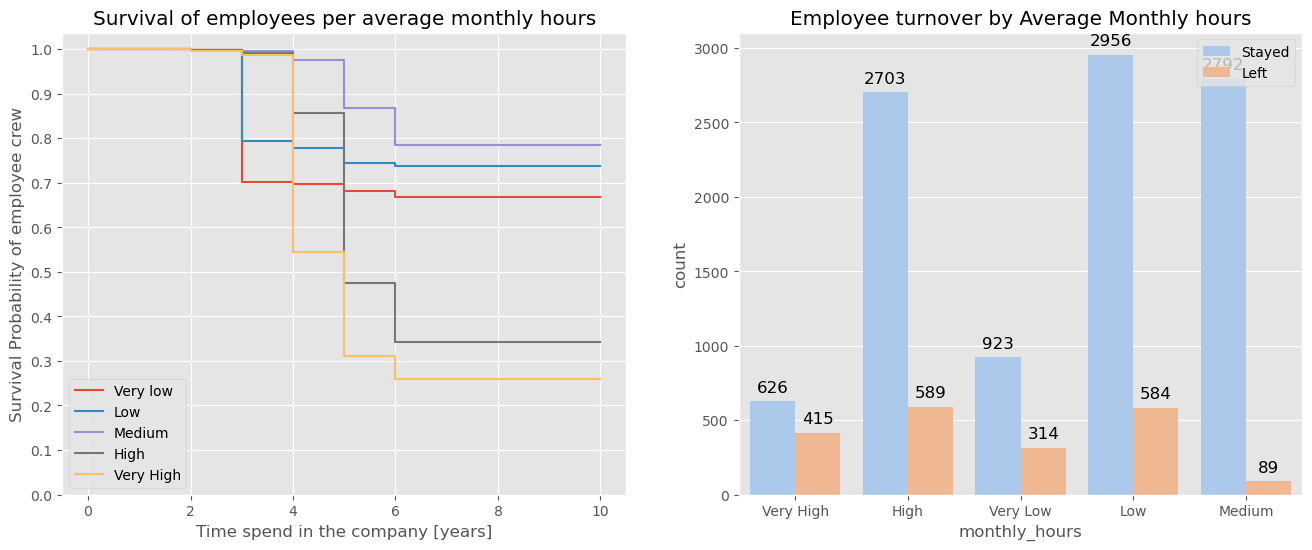

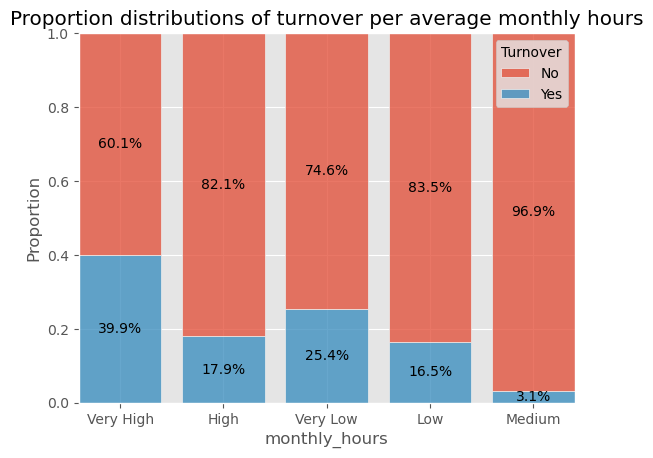

In [140]:
df0['average_monthly_hours'].describe()
range = 310-96
step = range/5

bin1 = (df0['average_monthly_hours'] < 96 + step)
bin2 =  (96+ step <= df0['average_monthly_hours']) & (df0['average_monthly_hours'] < 96 + 2*step)
bin3 =  (96+ 2*step <= df0['average_monthly_hours']) & (df0['average_monthly_hours'] < 96 + 3*step)
bin4 =  (96+ 3*step <= df0['average_monthly_hours']) & (df0['average_monthly_hours'] < 96 + 4*step)
bin5 =  (96+ 4*step <= df0['average_monthly_hours']) & (df0['average_monthly_hours'] < 96 + 5*step)

labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
order = ['Very High', 'High', 'Very Low', 'Low', 'Medium' ]
df_copy['monthly_hours'] = pd.cut(df0['average_monthly_hours'], bins=5, labels=labels, right=False)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

kmf.fit(timevar[bin1],event_observed = eventvar[bin1],label = "Very low")
plot1 = kmf.plot(ax = axs[0], ci_show=False)

kmf.fit(timevar[bin2],event_observed = eventvar[bin2],label = "Low")
plot2 = kmf.plot(ax = plot1, ci_show=False)

kmf.fit(timevar[bin3],event_observed = eventvar[bin3],label = "Medium")
plot3 = kmf.plot(ax = plot2, ci_show=False)

kmf.fit(timevar[bin4],event_observed = eventvar[bin4],label = "High")
plot4 = kmf.plot(ax = plot3, ci_show=False)

kmf.fit(timevar[bin5],event_observed = eventvar[bin5],label = "Very High")
plot5 = kmf.plot(ax = plot4, ci_show=False)

axs[0].set_title('Survival of employees per average monthly hours')
axs[0].set_xlabel('Time spend in the company [years]')
axs[0].set_ylabel('Survival Probability of employee crew')
axs[0].set_yticks(np.linspace(0,1,11))

axs[1] = sns.countplot(x='monthly_hours', hue='left', data=df_copy, palette='pastel', order=order)

for p in axs[1].patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
axs[1].legend(labels=['Stayed', 'Left'], loc='upper right', prop={'size' : 10})
axs[1].set_title('Employee turnover by Average Monthly hours')

plt.show()

# Stacked bar chart

df_copy['monthly_hours'] = pd.Categorical(df_copy['monthly_hours'], ['Very High','High','Very Low','Low', 'Medium'])

fig, ax = plt.subplots()
f = sns.histplot(
    data=df_copy, ax = ax,
    x="monthly_hours", hue="left",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8)
legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.legend(handles, ['No', 'Yes'], title='Turnover')
plt.title('Proportion distributions of turnover per average monthly hours')

for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
plt.show()

## Last Evaluation <a id='evaluation'></a>

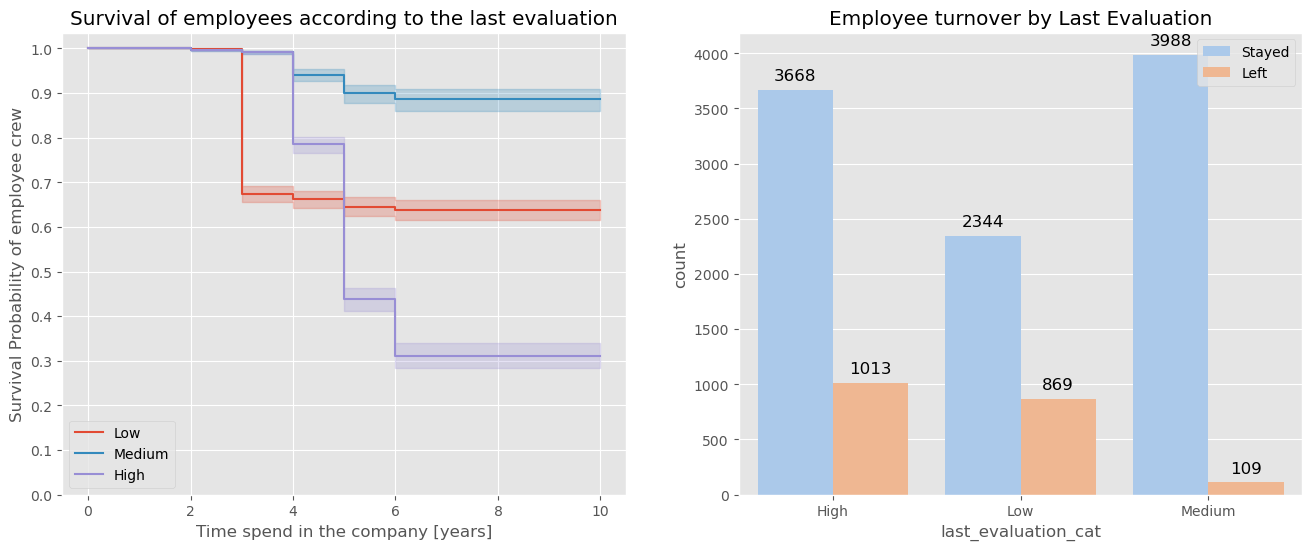

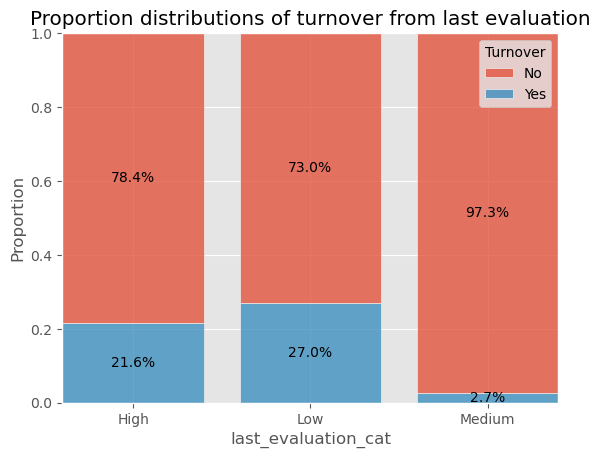

In [63]:
df0['last_evaluation'].describe()

range = 1-0.36
step = range/3

bin1 = (df0['last_evaluation'] < 0.36 +step)
bin2 = (df0['last_evaluation'] >= 0.36 + step) & (df0['last_evaluation'] < 0.36 +2*step)
bin3 = (df0['last_evaluation'] >= 0.36 + 2*step) & (df0['last_evaluation'] <= 0.36 +3*step)

labels = ['Low', 'Medium', 'High']
order = ['High', 'Low', 'Medium' ]
df_copy['last_evaluation_cat'] = pd.cut(df0['last_evaluation'], bins=3, labels=labels, right=False)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

kmf.fit(timevar[bin1], event_observed = eventvar[bin1], label = "Low")
plot1 = kmf.plot(ax = axs[0])

kmf.fit(timevar[bin2], event_observed = eventvar[bin2], label = "Medium")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[bin3], event_observed = eventvar[bin3], label = "High")
plot3 = kmf.plot(ax = plot2)

axs[0].set_title('Survival of employees according to the last evaluation')
axs[0].set_xlabel('Time spend in the company [years]')
axs[0].set_ylabel('Survival Probability of employee crew')
axs[0].set_yticks(np.linspace(0,1,11))

axs[1] = sns.countplot(x='last_evaluation_cat', hue='left', data=df_copy, palette='pastel', order=order)
for p in axs[1].patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
axs[1].legend(labels=['Stayed', 'Left'], loc='upper right', prop={'size' : 10})
axs[1].set_title('Employee turnover by Last Evaluation')

plt.show()

# Stacked Bar Chart
df_copy['last_evaluation_cat'] = pd.Categorical(df_copy['last_evaluation_cat'], ['High','Low', 'Medium'])

fig, ax = plt.subplots()
f = sns.histplot(
    data=df_copy, ax = ax,
    x="last_evaluation_cat", hue="left",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8)
legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.legend(handles, ['No', 'Yes'], title='Turnover')

plt.title('Proportion distributions of turnover from last evaluation')

for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
plt.show()

## Satisfaction <a id='satisfaction'></a>

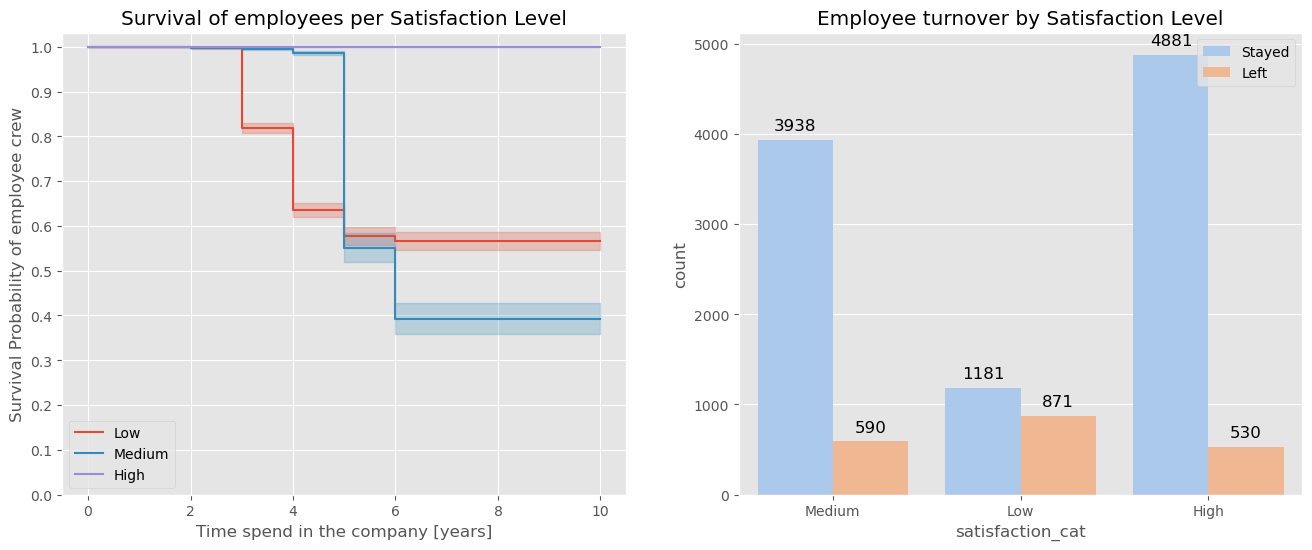

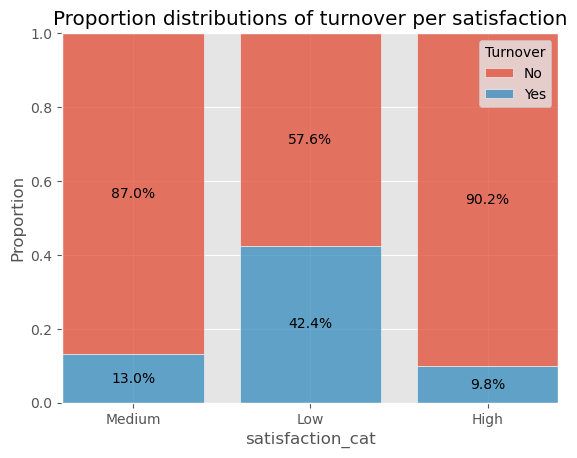

In [64]:
df0['satisfaction_level'].describe()
range = 1-0.09
step = range/3

bin1 = (df0['satisfaction_level'] < 0.36 +step)
bin2 = (df0['satisfaction_level'] >= 0.36 + step) & (df0['satisfaction_level'] < 0.36 +2*step)
bin3 = (df0['satisfaction_level'] >= 0.36 + 2*step) & (df0['satisfaction_level'] <= 0.36 +3*step)

labels = ['Low', 'Medium', 'High']
order = ['Medium', 'Low', 'High']
df_copy['satisfaction_cat'] = pd.cut(df0['satisfaction_level'], bins=3, labels=labels, right=False)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

kmf.fit(timevar[bin1], event_observed = eventvar[bin1], label = "Low")
plot1 = kmf.plot(ax = axs[0])

kmf.fit(timevar[bin2], event_observed = eventvar[bin2], label = "Medium")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[bin3], event_observed = eventvar[bin3], label = "High")
plot3 = kmf.plot(ax = plot2)

axs[0].set_title('Survival of employees per Satisfaction Level')
axs[0].set_xlabel('Time spend in the company [years]')
axs[0].set_ylabel('Survival Probability of employee crew')
axs[0].set_yticks(np.linspace(0,1,11))

axs[1] = sns.countplot(x='satisfaction_cat', hue='left', data=df_copy, palette='pastel', order=order)
for p in axs[1].patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
axs[1].legend(labels=['Stayed', 'Left'], loc='upper right', prop={'size' : 10})
axs[1].set_title('Employee turnover by Satisfaction Level')

plt.show()

# Stacked Bar Chart
df_copy['satisfaction_cat'] = pd.Categorical(df_copy['satisfaction_cat'], ['Medium', 'Low', 'High'])

fig, ax = plt.subplots()
f = sns.histplot(
    data=df_copy, ax = ax,
    x="satisfaction_cat", hue="left",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8)
legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.legend(handles, ['No', 'Yes'], title='Turnover')

plt.title('Proportion distributions of turnover per satisfaction')

for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
plt.show()

## Work Accidents <a id='accidents'></a>

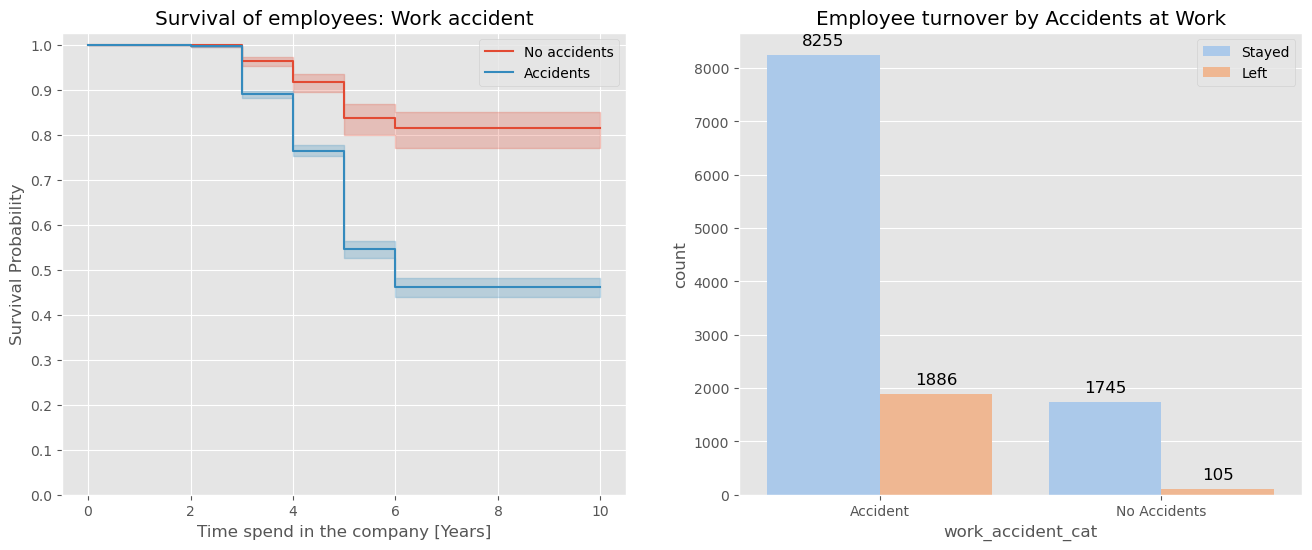

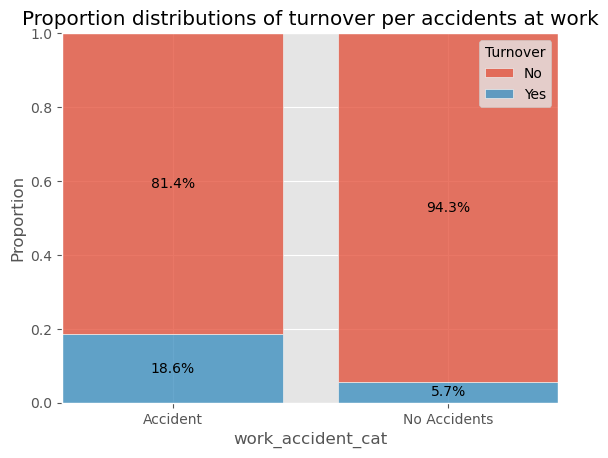

In [65]:
noaccident = (df0['work_accident'] == 1)
accident = (df0['work_accident'] == 0)

accident_mapping = {1: 'No Accidents', 0: 'Accident'}
df_copy['work_accident_cat'] = df0['work_accident'].map(accident_mapping)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

kmf.fit(timevar[noaccident],event_observed = eventvar[noaccident],label = "No accidents")
plot1 = kmf.plot(ax = axs[0])

kmf.fit(timevar[accident],event_observed = eventvar[accident],label = "Accidents")
plot2 = kmf.plot(ax = plot1)

axs[0].set_title('Survival of employees: Work accident')
axs[0].set_xlabel('Time spend in the company [Years]')
axs[0].set_ylabel('Survival Probability')
axs[0].set_yticks(np.linspace(0,1,11))

axs[1] = sns.countplot(x='work_accident_cat', hue='left', data=df_copy, palette='pastel')
for p in axs[1].patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
axs[1].legend(labels=['Stayed', 'Left'], loc='upper right', prop={'size' : 10})
axs[1].set_title('Employee turnover by Accidents at Work')

plt.show()

# Stacked Bar Chart

fig, ax = plt.subplots()
f = sns.histplot(
    data=df_copy, ax = ax,
    x="work_accident_cat", hue="left",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8)
legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.legend(handles, ['No', 'Yes'], title='Turnover')

plt.title('Proportion distributions of turnover per accidents at work')

for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
plt.show()

## Number of Projects <a id='projects'></a>

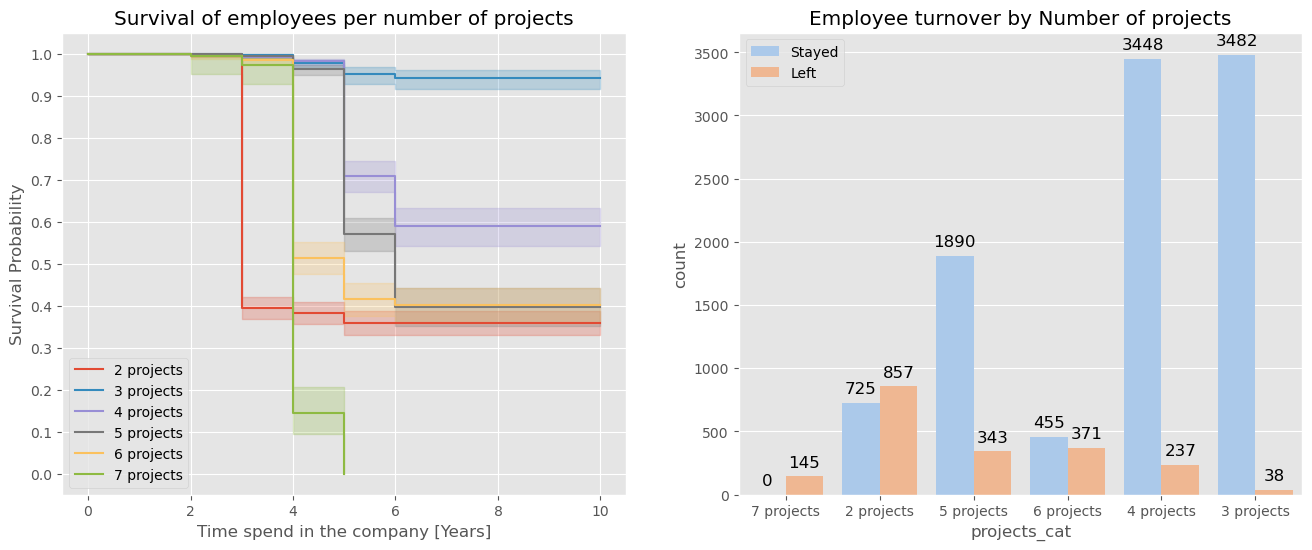

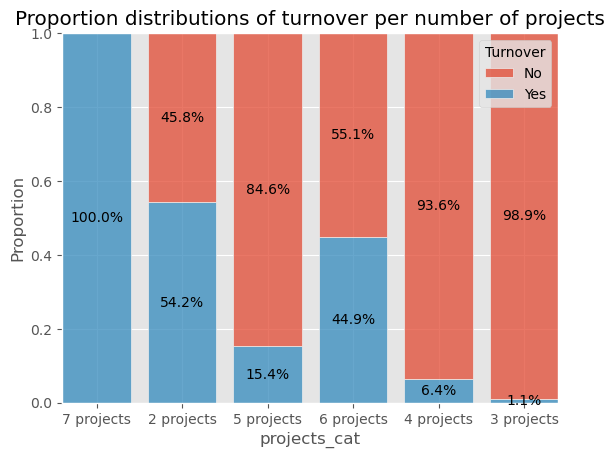

In [66]:
projects2 = (df0['number_project'] == 2)
projects3 = (df0['number_project'] == 3)
projects4 = (df0['number_project'] == 4)
projects5 = (df0['number_project'] == 5)
projects6 = (df0['number_project'] == 6)
projects7 = (df0['number_project'] == 7)

projects = {2: '2 projects', 3: '3 projects', 4: '4 projects', 5: '5 projects', 6: '6 projects', 7: '7 projects'}
order = ['7 projects', '2 projects', '5 projects', '6 projects', '4 projects', '3 projects']
df_copy['projects_cat'] = df0['number_project'].map(projects)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

kmf.fit(timevar[projects2],event_observed = eventvar[projects2],label = "2 projects")
plot1 = kmf.plot(ax = axs[0])

kmf.fit(timevar[projects3],event_observed = eventvar[projects3],label = "3 projects")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[projects4],event_observed = eventvar[projects4],label = "4 projects")
plot3 = kmf.plot(ax = plot2)

kmf.fit(timevar[projects5],event_observed = eventvar[projects5],label = "5 projects")
plot4 = kmf.plot(ax = plot3)

kmf.fit(timevar[projects6],event_observed = eventvar[projects6],label = "6 projects")
plot5 = kmf.plot(ax = plot4)

kmf.fit(timevar[projects7],event_observed = eventvar[projects7],label = "7 projects")
plot6 = kmf.plot(ax = plot5)

axs[0].set_title('Survival of employees per number of projects')
axs[0].set_xlabel('Time spend in the company [Years]')
axs[0].set_ylabel('Survival Probability')
axs[0].set_yticks(np.linspace(0,1,11))

axs[1] = sns.countplot(x='projects_cat', hue='left', data=df_copy, palette='pastel', order = order)
for p in axs[1].patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
axs[1].legend(labels=['Stayed', 'Left'], loc='upper left', prop={'size' : 10})
axs[1].set_title('Employee turnover by Number of projects')
plt.show()

# Stacked bar chart
df_copy['projects_cat'] = pd.Categorical(df_copy['projects_cat'], ['7 projects', 
         '2 projects', '5 projects', '6 projects', '4 projects', '3 projects'])

fig, ax = plt.subplots()
f = sns.histplot(
    data=df_copy, ax = ax,
    x="projects_cat", hue="left",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8)
legend = ax.get_legend()
handles = legend.legend_handles
legend.remove()
ax.legend(handles, ['No', 'Yes'], title='Turnover')

plt.title('Proportion distributions of turnover per number of projects')

for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
plt.show()


## Cox Proportional Harzard Model <a id='coxproportional'></a>

In [141]:
#survival_df = df_copy[['salary', 'department', 'promotion_last_5years', 'monthly_hours', 'last_evaluation_cat',
#         'satisfaction_cat', 'work_accident', 'tenure', 'left', 'projects_cat']]
survival_df = df_copy[['salary_encoded', 'promotion_last_5years', 'average_monthly_hours', 'last_evaluation', 'satisfaction_level', 'work_accident', 'number_project', 'tenure', 'left']]
survival_df = pd.concat([survival_df, df0['department']], axis=1)
survival_df.head(7)

,salary_encoded,promotion_last_5years,average_monthly_hours,last_evaluation,satisfaction_level,work_accident,number_project,tenure,left,department
0,0,0,157,0.53,0.38,0,2,3,1,0
1,1,0,262,0.86,0.80,0,5,6,1,0
2,1,0,272,0.88,0.11,0,7,4,1,0
3,0,0,223,0.87,0.72,0,5,5,1,0
4,0,0,159,0.52,0.37,0,2,3,1,0
5,0,0,153,0.50,0.41,0,2,3,1,0
6,0,0,247,0.77,0.10,0,6,4,1,0


In [142]:
cph = CoxPHFitter()
cph.fit(survival_df, duration_col='tenure', event_col='left')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 11991 total observations, 10000 right-censored observations>
             duration col = 'tenure'
                event col = 'left'
      baseline estimation = breslow
   number of observations = 11991
number of events observed = 1991
   partial log-likelihood = -15905.23
         time fit was run = 2023-12-22 01:59:00 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
salary_encoded         -0.52       0.59       0.04            -0.60            -0.44                 0.55                 0.64
promotion_last_5years  -1.44       0.24       0.35            -2.14            -0.75                 0.12                 0.47
average_monthly_hours   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
last_evaluation        -0.09       0.91       0.14            -0.37             0.18                 0.69                 1.20
satisfaction_level     -2.41       0.09       0.09            -2.59            -2.23                 0.08                 0.11
work_accident          -1.25       0.29       0.10            -1.44            -1.05                 0.24                 0.35
number_project         -0.29       0.75       0.02            -0.33            -0.25                 0.72                 0.78
department             -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00

                        cmp to      z      p   -log2(p)
covariate                                              
salary_encoded            0.00 -13.24 <0.005     130.48
promotion_last_5years     0.00  -4.06 <0.005      14.31
average_monthly_hours     0.00   3.77 <0.005      12.58
last_evaluation           0.00  -0.66   0.51       0.98
satisfaction_level        0.00 -26.79 <0.005     522.65
work_accident             0.00 -12.41 <0.005     115.09
number_project            0.00 -14.65 <0.005     159.04
department                0.00  -1.83   0.07       3.88
---
Concordance = 0.84
Partial AIC = 31826.47
log-likelihood ratio test = 1318.58 on 8 df
-log2(p) of ll-ratio test = 925.64

In [143]:
test_id = survival_df.sample(1)

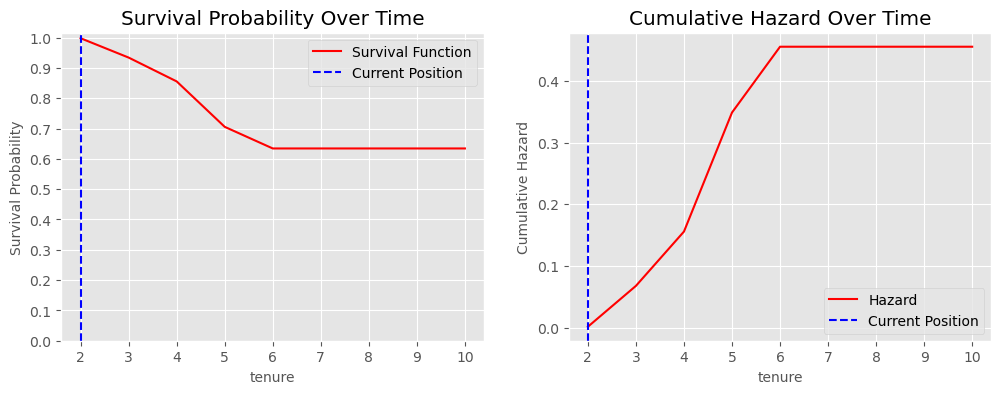

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Survival Probability Function
cph.predict_survival_function(test_id).plot(ax=axs[0], color='red')
axs[0].axvline(x=test_id['tenure'].values[0], color='blue', linestyle='--')
axs[0].legend(labels=['Survival Function', 'Current Position'])
axs[0].set_yticks(np.linspace(0, 1, 11))
axs[0].set_xlabel('tenure', size=10)
axs[0].set_ylabel('Survival Probability', size=10)
axs[0].set_title('Survival Probability Over Time')

# Cumulative Hazard Function
cph.predict_cumulative_hazard(test_id).plot(ax=axs[1], color='red')
axs[1].axvline(x=test_id['tenure'].values[0], color='blue', linestyle='--')
axs[1].legend(labels=['Hazard', 'Current Position'])
axs[1].set_xlabel('tenure', size=10)
axs[1].set_ylabel('Cumulative Hazard', size=10)
axs[1].set_title('Cumulative Hazard Over Time')

plt.show()

# Machine Learning Implementation <a id='mlimplementation'></a>

In [144]:
y = survival_df['left']
X = survival_df.drop("left", axis=1)

scoring = {'accuracy': 'accuracy',
    'precision': 'precision_macro', 
    'recall': 'recall_macro',
    'f1': 'f1_macro'}

for key in ['precision']:
    scoring[key] = metrics.make_scorer(precision_score, zero_division=1)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25, random_state =42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size=0.2, random_state = 42)

## Tuned Decision Tree <a id='decision'></a>
### Grid 1: Selecting max depth and min sample leaf

In [152]:
tuned_dt = DecisionTreeClassifier(random_state = 0)

tree_grid1 = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

grid1 = GridSearchCV(estimator = tuned_dt, param_grid = tree_grid1,
                   scoring = scoring, cv=5, refit="f1")

# Fit the model
grid1.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': 'recall_macro'})

In [153]:
grid1.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, random_state=0)

#### Grid 2: Selecting max depth and min sample leaf

In [154]:
tree_grid2 = {'max_features':[2,3,4,5, None],
              'min_samples_leaf': [2, 3, 4, 5, 6, 7],
              'max_leaf_nodes': [2, 4, 5, 6, 8],
           'criterion': ['entropy', 'gini'],
             'max_depth': [7]}

grid2 = GridSearchCV(estimator = tuned_dt, param_grid = tree_grid2, 
                   scoring = scoring, cv=5, refit="f1")

# Fit the model
grid2.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [7],
                         'max_features': [2, 3, 4, 5, None],
                         'max_leaf_nodes': [2, 4, 5, 6, 8],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': 'recall_macro'})

In [155]:
grid2.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_leaf_nodes=8,
                       min_samples_leaf=2, random_state=0)

In [156]:
tree_para = {'min_samples_leaf': [2],
              'max_leaf_nodes': [8],
             'max_depth': [7],
            'criterion': ['entropy']}

dtc = GridSearchCV(estimator = tuned_dt, 
                   param_grid = tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")

# Fit the model
dtc.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['entropy'], 'max_depth': [7],
                         'max_leaf_nodes': [8], 'min_samples_leaf': [2]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': 'recall_macro'})

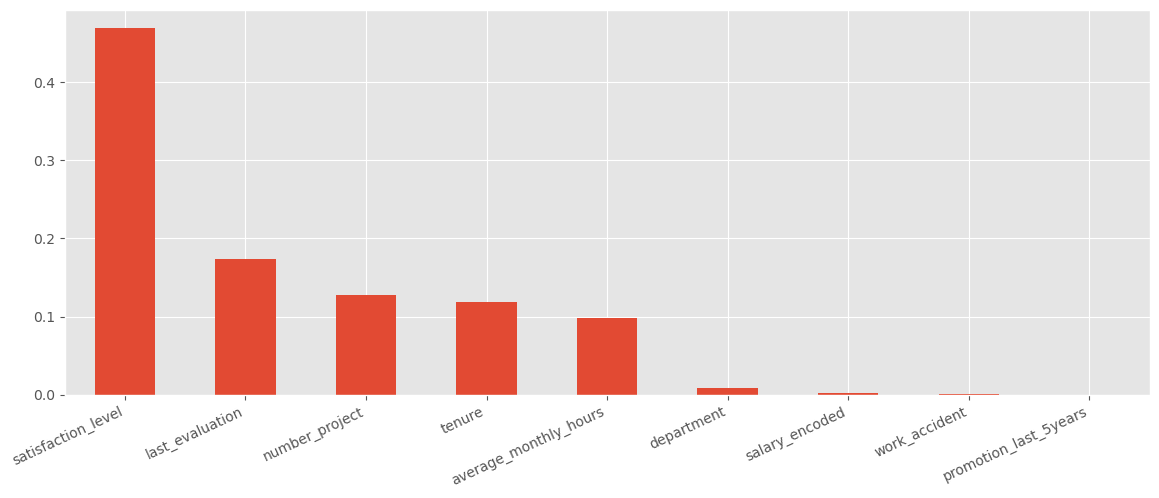

In [157]:
tuned_dt.fit(X_train, y_train)
importances = tuned_dt.feature_importances_

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14,5))
forest_importances.plot.bar(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
plt.show()

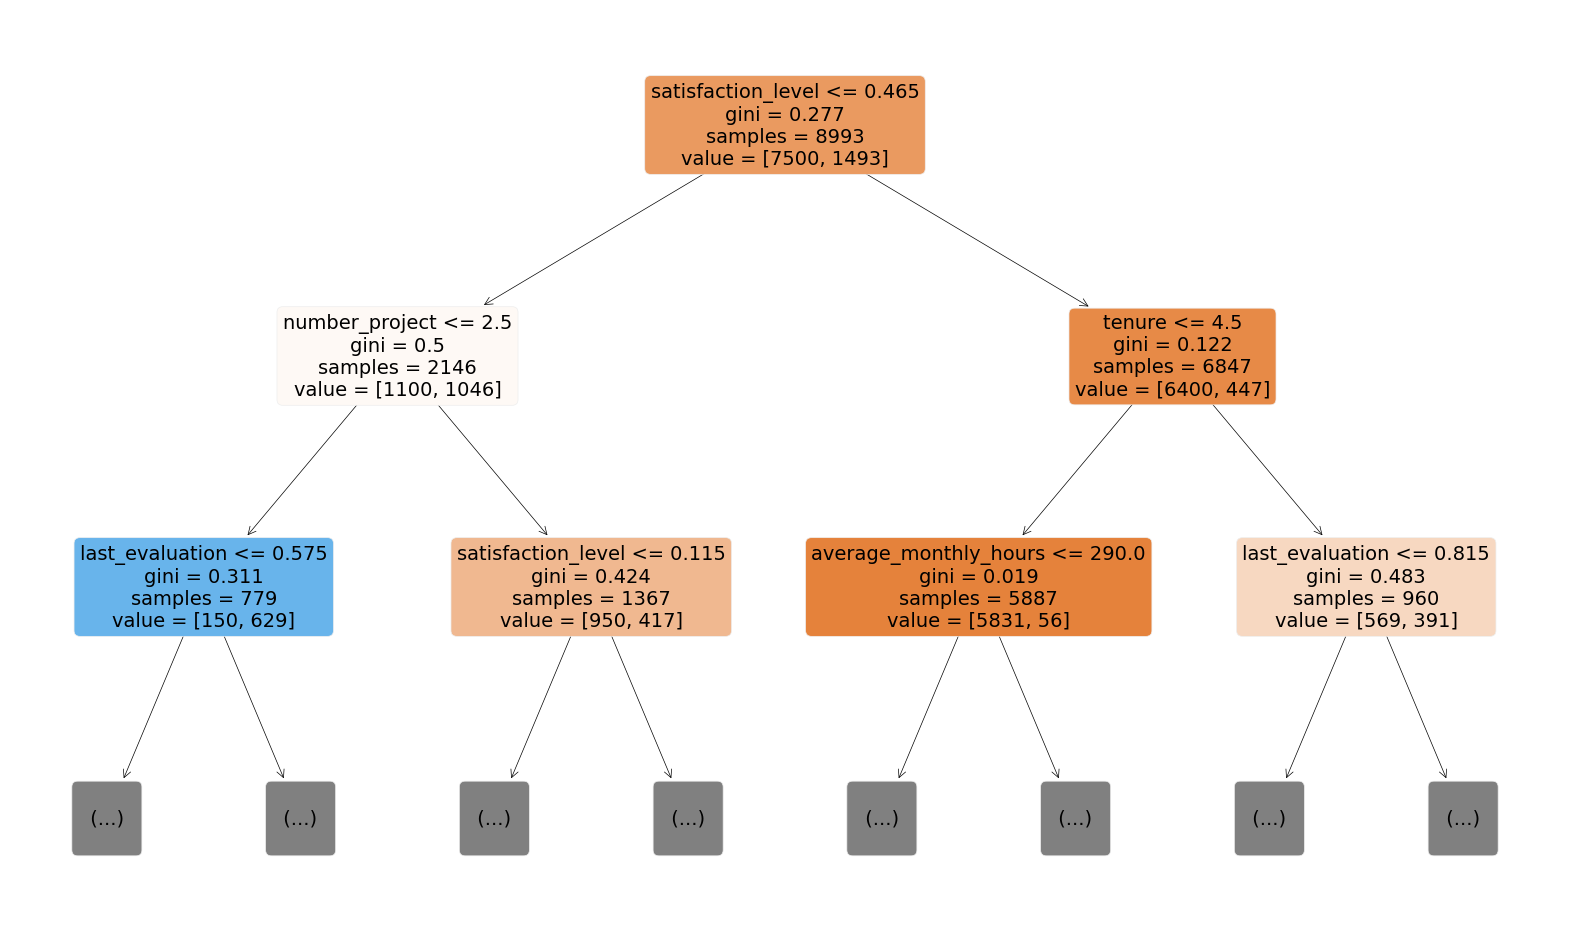

In [158]:
plt.figure(figsize=(20,12))
plot_tree(tuned_dt, max_depth=2, fontsize=14,
              feature_names=list(X.columns),
              filled=True, 
              rounded=True)


plt.show()

## Random Forest Classificator <a id='forest'></a>
### Grid 1: Selecting max features and number of estimators

In [159]:
rf = RandomForestClassifier(random_state=0)

cv_params = {
             'max_features': [2,3,4, None],
             'n_estimators': [75, 100, 125, 150]
             }

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',  # Use precision_macro to avoid ill-defined precision
    'recall': 'recall_macro',  # Use recall_macro to avoid ill-defined recall
    'f1': 'f1_macro'  # Use f1_macro to avoid ill-defined F1 score
}


grid1 = GridSearchCV(estimator=rf, param_grid= cv_params, n_jobs=-1, cv=3, verbose=1, scoring = scoring, refit='f1')
grid1.fit(X_tr, y_tr)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_features': [2, 3, 4, None],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': 'precision_macro',
                      'recall': 'recall_macro'},
             verbose=1)

In [160]:
grid1.best_estimator_

RandomForestClassifier(max_features=3, n_estimators=75, random_state=0)

#### Grid 2: Selecting max features, criterion, and max depth

In [161]:
param_grid2 = {'max_features':[3],
          'n_estimators':[65, 70, 75, 85, 95],
           'criterion': ['entropy', 'gini'],    
          'max_depth': [7, 9, 11, 13, 15, None],
         }


grid2 = GridSearchCV(estimator=rf, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2.fit(X_tr, y_tr)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [7, 9, 11, 13, 15, None],
                         'max_features': [3],
                         'n_estimators': [65, 70, 75, 85, 95]},
             scoring='f1', verbose=1)

In [162]:
grid2.best_estimator_

RandomForestClassifier(max_depth=11, max_features=3, n_estimators=95,
                       random_state=0)

#### Grid 3: Selecting num. of estimators and min child weight

In [163]:
param_grid3 = {'max_features':[3],
          'n_estimators':[95],    
          'max_depth': [11],
          'min_samples_leaf': [1, 3, 5, 7],
          'min_samples_split': [2, 4, 6, 8]
         }
rfc = GridSearchCV(estimator=rf, param_grid=param_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
rfc.fit(X_tr, y_tr)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [11], 'max_features': [3],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [95]},
             scoring='f1', verbose=1)

In [164]:
rfc.best_estimator_

RandomForestClassifier(max_depth=11, max_features=3, n_estimators=95,
                       random_state=0)

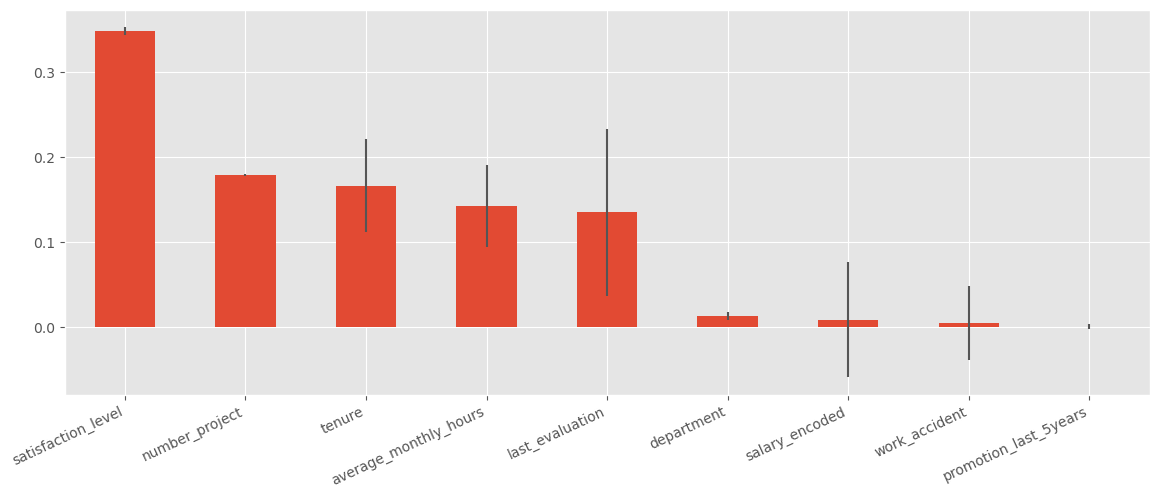

In [165]:
rf.fit(X_train, y_train)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
plt.show()

## XGBoost <a id='xgboost'></a>
### Grid 1: Selecting max depth and learning rate

In [146]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

cv_grid1 = {'max_depth': [4,5,6,7,8], 
             'learning_rate': [0.1, 0.2, 0.3],}    

xgb_grid1 = GridSearchCV(estimator = xgb, param_grid = cv_grid1, scoring=scoring, cv=5, refit='f1')
xgb_grid1.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': 'recall_macro'})

In [147]:
xgb_grid1.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

#### Grid 2: Selecting num. of estimators and min child weight

In [148]:
cv_grid2 = {'max_depth': [7, 9, 11], 
            'learning_rate': [0.1],
            'n_estimators': [75, 100, 125],
            'min_child_weight': [1,2,3,4,5],}    

xgb_grid2 = GridSearchCV(estimator = xgb, param_grid = cv_grid2, scoring=scoring, cv=5, refit='f1')
xgb_grid2.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [7, 9, 11],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': 'recall_macro'})

In [149]:
xgb_grid2.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

#### Grid 2: Selecting num. of estimators and min child weight

In [150]:
cv_grid2 = {'max_depth': [7], 
            'learning_rate': [0.1],
            'n_estimators': [100],
            'min_child_weight': [1],}    

xgb = GridSearchCV(estimator = xgb, param_grid = cv_grid2, scoring=scoring, cv=5, refit='f1')
xgb.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [7],
                         'min_child_weight': [1], 'n_estimators': [100]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': 'recall_macro'})

In [166]:
# Decision Tree
pred_dt = dtc.predict(X_val)
fpr_dt, tpr_dt, threshold = metrics.roc_curve(y_val, pred_dt)
roc_auc_dt = metrics.auc(fpr_dt, tpr_dt)
# Random Forest
pred_rfc = rfc.predict(X_val)
fpr_rfc, tpr_rfc, threshold = metrics.roc_curve(y_val, pred_rfc)
roc_auc_rfc = metrics.auc(fpr_rfc, tpr_rfc)
# XGBoost
pred_xgb = xgb.predict(X_val)
fpr_xgb, tpr_xgb, threshold = metrics.roc_curve(y_val, pred_xgb)
roc_auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

results = pd.DataFrame({'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
             'Accuracy': [accuracy_score(y_val, pred_dt), accuracy_score(y_val, pred_rfc), accuracy_score(y_val, pred_xgb)],
             'Precision': [precision_score(y_val, pred_dt), precision_score(y_val, pred_rfc), precision_score(y_val, pred_xgb)],
             'Recall': [recall_score(y_val, pred_dt), recall_score(y_val, pred_rfc), recall_score(y_val, pred_xgb)],
             'F1': [f1_score(y_val, pred_dt), f1_score(y_val, pred_rfc), f1_score(y_val, pred_xgb)],
             'Area under ROC': [roc_auc_dt, roc_auc_rfc, roc_auc_xgb]})

results = results.set_index('Model').round(3)
results

,Accuracy,Precision,Recall,F1,Area under ROC
Model,,,,,
Decision Tree,0.974,0.917,0.930,0.924,0.957
Random Forest,0.990,0.996,0.943,0.969,0.971
XGBoost,0.989,0.993,0.943,0.967,0.971


### Random Forest Classificator
#### Grid 1: Selecting max features and number of estimators

## Final Model <a id='finalmodel'></a>

In [167]:
predictions = xgb.predict(X_test)
probabilities = xgb.predict_proba(X_test)[:,1]

In [168]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

print("\nClassification report: Test data")
results = pd.DataFrame({'Accuracy': [accuracy_score(y_test, predictions)],
             'Precision': [precision_score(y_test, predictions)],
             'Recall': [recall_score(y_test, predictions)],
             'F1': [f1_score(y_test, predictions)],
             'Area under ROC': [roc_auc]})
results.round(3)


Classification report: Test data


,Accuracy,Precision,Recall,F1,Area under ROC
0,0.983,0.977,0.92,0.947,0.958


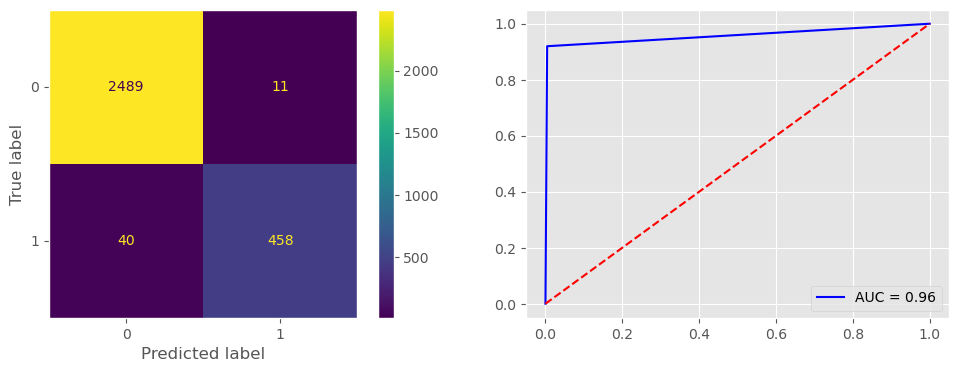

In [169]:
model_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, model_pred, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

disp.plot(values_format='', ax=axs[0])  # `values_format=''` suppresses scientific notation
axs[0].grid(False)
#axs[0].title('Confusion Matrix')

#axs[1].title('Receiver Operating Characteristic')
axs[1].plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
axs[1].legend(loc='lower right')
axs[1].plot([0, 1], [0, 1], 'r--')
#axs[1].xlim([0, 1])
#axs[1].ylim([0, 1])
#axs[1].ylabel('True Positive Rate')
#axs[1].xlabel('False Positive Rate')
axs[1].grid(True)
plt.show()

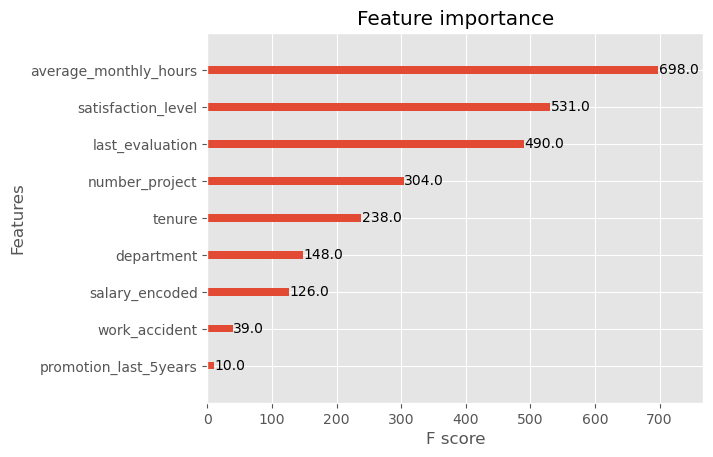

In [170]:
plot_importance(xgb.best_estimator_)
plt.show()